<a href="https://colab.research.google.com/github/eunzzae/Study_DS/blob/main/07)_%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EC%B1%84%EB%AC%B4_%EB%B6%88%EC%9D%B4%ED%96%89_%EA%B3%A0%EA%B0%9D_%EC%98%88%EC%B8%A1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용카드 채무 불이행 고객 예측  
> **목차**
* 문제상황 및 데이터 살펴보기  
* 문제해결  프로세스 정의  
1) 신용카드 사용패턴 탐색  
2) 이용한도 수준에 따른 채무 불이행 분석  
3) ML 활용 채무 불이행 고객 예측


In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# # ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter05')
# # '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter05' ← 변경X
# os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 문제상황 및 데이터 살펴보기
---
> **시나리오**

```
카드사 A는 최근 점점 늘어가는 채무 불이행 고객 때문에 골치를 썩고 있다. 네이버페이, 카카오페이 등 간편결제 회사와 같은 경쟁사들이 등장하고  
있는 어려운 상황에서 채무 불이행 고객으로 인한 손실이 늘어나고 있는 상황이다. 이에 신용카드 채무 불이행이 예상되는 고객들을 블랙리스트로  
관리하고, 한도를 줄여서 최대한의 손실을 막아보고자 한다.

```  


> **데이터 살펴보기**
* 고객 ID별 카드 Spending data
* 데이터 명세 ⬇

|ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|
|:---:|:---:|:---:|:---:|:---:|:---:|
|고객 아이디|신용한도|성별(1-남성, 2-여성)|교육수준(1-대학원, 2-대학교, 3-고등학교, 4-기타, 5-모름, 6-모름)|결혼(1-기혼, 2-독신, 3-기타)|나이||
|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|
|05년9월 상환상태(-2-무소비, -1-정액 결제, 0-리볼빙크레딧, 1-한달 지연, ..., 9-9개월 지불지연)|05년8월 상환상태|05년7월 상환상태|05년6월 상환상태|05년5월 상환상태|05년4월 상환상태|
|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|
|05년9월 청구서 금액|05년8월 청구서 금액|05년7월 청구서 금액|05년6월 청구서 금액|05년5월 청구서 금액|05년4월 청구서 금액|
|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|
|05년9월 지불금액|05년8월 지불금액|05년7월 지불금액|05년6월 지불금액|05년5월 지불금액|05년4월 지불금액|
|default payment next month|
|채무 불이행 여부|

In [2]:
import pandas as pd
bath = '/content/drive/MyDrive/[STUDY] 데이터사이언스/데이터분석/data/chapter07_신용카드 채무 불이행 고객 예측/'
df = pd.read_excel(bath + 'chapter07_credit_card_pay.xlsx')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 문제해결 프로세스 정의  
---
> **문제정의**
```
- 신용카드 대금 채무 불이행으로 인한 손실
```

> **기대효과**
```
- 채무 불이행으로 인한 손실 감소
```

> **해결방안**
```
- 채무 불이행 고객 예측 및 블랙리스트 관리(신용한도 조정)
- Session 1
  - 고객 프로필 정보 확인 및 파생변수 생성 및 검증
- Session 2
  - 고객 프로필 정보, 이용한도에 따른 채무 불이행률 탐색
- Session 3
  - ML알고리즘 활용 채무 불이행 고객 예측
```

> **성과측정**
```
- 블랙리스트 관리 후 채무 불이행 손실 감소률(%)
```

> **현업적용**
```
- 매 월 Model에 Input하기 위한 Data mart 생성
- Data mart 에측 Model에 Input후 채무 불이행 예측 고객군 추출  
- 추출한 고객 대상으로 신용한도 조정 및 블랙리스트 관리를 통한 손실 방어
```

## Session 1  
## 신용카드 사용패턴 탐색

### Data 전처리
---
1) Data shape  
2) Data type  
3) Null 확인
4) Outlier 확인

In [3]:
# Data 형태 확인
# 30000 row, 25 col로 구성됨.
print('df', df.shape)

df (30000, 25)


In [4]:
# Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [5]:
# null
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [6]:
# Outlier
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [7]:
df['default payment next month'].value_counts()

default payment next month
0    23364
1     6636
Name: count, dtype: int64

In [8]:
# 채무 불이행률 22.12%
(6636/(23364+6636))*100

22.12

### 고객 프로필 정보 확인
---

In [9]:
# 고객 프로필 정보 col
df.columns[1:5]

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE'], dtype='object')

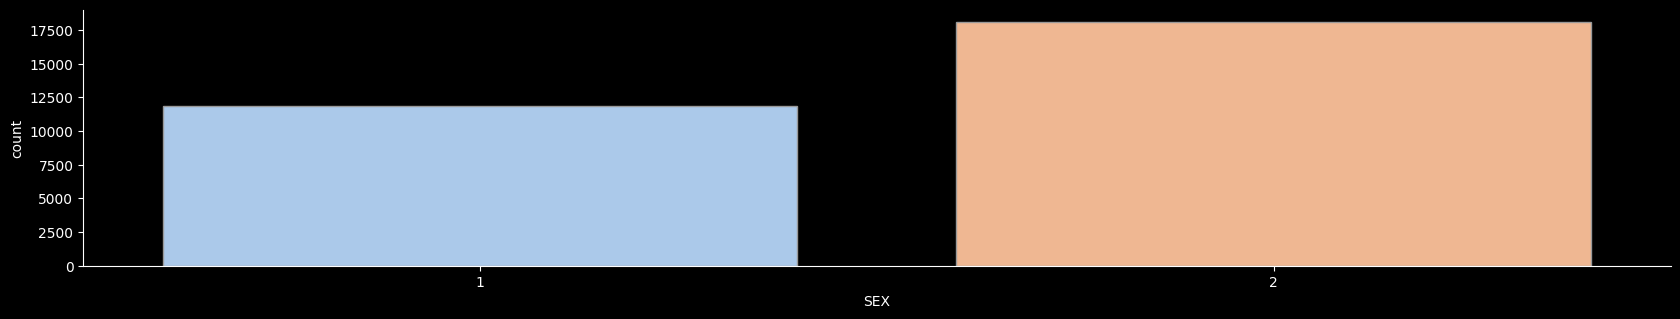

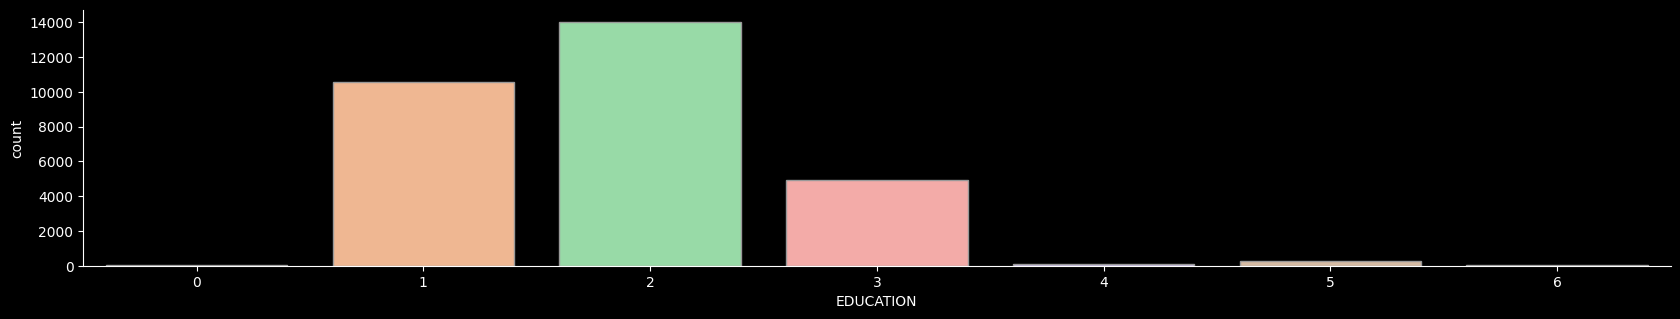

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

# 성별 (1-남, 2-여)
sns.catplot(x='SEX', kind='count', palette='pastel', edgecolor='.6', data=df)
plt.gcf().set_size_inches(20,3)

# 교육수준(1-대학원, 2-대학, 3-고등학교, 4-기타)
sns.catplot(x='EDUCATION', kind='count', palette='pastel', edgecolor='.6', data=df)
plt.gcf().set_size_inches(20,3)

In [11]:
# 교육 수준이 0, 4, 5, 6은 데이터가 너무 적으므로 하나의 카테고리로 통합
import numpy as np
df['EDUCATION']=np.where((df['EDUCATION']>=4)|(df['EDUCATION']==0), 4,df['EDUCATION'])

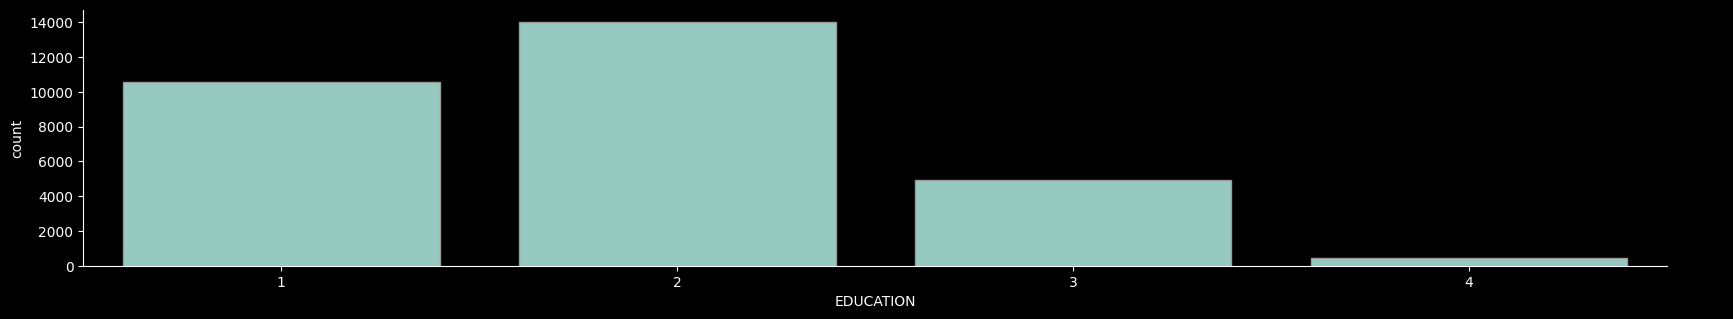

In [12]:
# 교육수준 통합
sns.catplot(x='EDUCATION', kind='count', edgecolor='.6', data=df)
plt.gcf().set_size_inches(20,3)

## 청구금액 대비 지불 수준 확인

In [13]:
# 청구 수준 대비 지불 수준 확인
# 청구 대비 지불이 낮다면 연쳬 확률 높을 것이고, 청고 대비 지불이 높다면 과거 연체비용까지 지불했을 가능성
df[['ID', 'BILL_AMT1', 'PAY_AMT1', 'BILL_AMT2', 'PAY_AMT2', 'BILL_AMT3', 'PAY_AMT3', 'BILL_AMT4', 'PAY_AMT4', 'BILL_AMT5', 'PAY_AMT5', 'BILL_AMT6', 'PAY_AMT6']]

,ID,BILL_AMT1,PAY_AMT1,BILL_AMT2,PAY_AMT2,BILL_AMT3,PAY_AMT3,BILL_AMT4,PAY_AMT4,BILL_AMT5,PAY_AMT5,BILL_AMT6,PAY_AMT6
0,1,3913,0,3102,689,689,0,0,0,0,0,0,0
1,2,2682,0,1725,1000,2682,1000,3272,1000,3455,0,3261,2000
2,3,29239,1518,14027,1500,13559,1000,14331,1000,14948,1000,15549,5000
3,4,46990,2000,48233,2019,49291,1200,28314,1100,28959,1069,29547,1000
4,5,8617,2000,5670,36681,35835,10000,20940,9000,19146,689,19131,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,188948,8500,192815,20000,208365,5003,88004,3047,31237,5000,15980,1000
29996,29997,1683,1837,1828,3526,3502,8998,8979,129,5190,0,0,0
29997,29998,3565,0,3356,0,2758,22000,20878,4200,20582,2000,19357,3100
29998,29999,-1645,85900,78379,3409,76304,1178,52774,1926,11855,52964,48944,1804


In [14]:
# 과거 6개월 동안 총 청구 대비 지불 수준을 확인하기 위해 새로운 col 생성
df['PAY/BILL'] = round(((df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6'])
                  / (df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6'])) * 100, 1)

In [15]:
df[df['PAY/BILL']==0]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,PAY/BILL
109,110,360000,1,2,1,35,1,-2,-2,-2,...,-103,-103,0,0,0,0,0,0,0,-0.0
173,174,50000,2,1,2,24,1,-2,-2,-2,...,-3272,-3272,0,0,0,0,0,0,1,-0.0
200,201,180000,2,1,1,38,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0.0
216,217,240000,2,2,1,36,1,-2,-2,-2,...,-946,-946,0,0,0,0,0,0,1,-0.0
258,259,100000,2,3,1,43,0,0,-2,-2,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29775,29776,210000,1,1,2,35,-1,2,2,-2,...,0,0,0,0,0,0,0,0,0,0.0
29900,29901,20000,1,2,2,29,0,0,-2,-2,...,0,0,0,0,0,0,0,0,1,0.0
29922,29923,150000,1,2,1,35,1,-2,-2,-2,...,-18,-18,0,0,0,0,0,0,0,-0.0
29986,29987,360000,1,1,2,35,-1,-1,-2,-2,...,0,0,0,0,0,0,0,0,0,0.0


In [16]:
# 총 청구 대금이 0인 고객이 존재할 경우, inf로 표현되기 때문에 전처리를 통해 제거
# NA인 경우 0으로 채움
df['PAY/BILL']=df['PAY/BILL'].replace([np.inf, -np.inf], np.nan)
df['PAY/BILL']=df['PAY/BILL'].fillna(0)

In [17]:
# 이상 Data 처리
df['PAY/BILL']=np.where(df['PAY/BILL']>100, 100, df['PAY/BILL'])
df['PAY/BILL']=np.where(df['PAY/BILL']<0,0,df['PAY/BILL'])

<Axes: xlabel='PAY/BILL', ylabel='Density'>

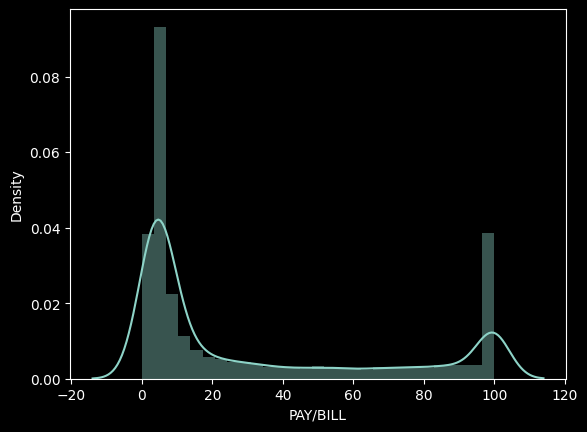

In [18]:
# 대부분 고객이 총 청구금액 대비 20% 수준에서만 지불하고 있음
sns.distplot(df['PAY/BILL'])

## Session 2
## 이용한도 수준에 따른 채무 불이행 분석  


### 고객 프로필 - 채무 불이행 분석
---

In [19]:
# 성별에 따른 채무 불이행 분석
df_profile = pd.DataFrame(df['default payment next month'].groupby(df['SEX']).value_counts())
df_profile.columns=['cnt']
df_profile = df_profile.reset_index()
df_profile

,SEX,default payment next month,cnt
0,1,0,9015
1,1,1,2873
2,2,0,14349
3,2,1,3763


In [20]:
# 2단계 (Pivot table)
df_profile = pd.pivot_table(df_profile, index='SEX', columns='default payment next month', values='cnt')
df_profile

default payment next month,0,1
SEX,,
1,9015,2873
2,14349,3763


In [21]:
df_profile

default payment next month,0,1
SEX,,
1,9015,2873
2,14349,3763


In [22]:
# 3 단계
df_profile = df_profile.reset_index()
df_profile.columns.names=['']
df_profile

,SEX,0,1
0,1,9015,2873
1,2,14349,3763


In [23]:
# 4단계
df_profile['ratio'] =   round((df_profile.iloc[:,2] / (df_profile.iloc[:,1] + df_profile.iloc[:,2])) * 100,1)

df_profile = df_profile.sort_values(by=['ratio'], ascending=False)
df_profile.head()

,SEX,0,1,ratio
0,1,9015,2873,24.2
1,2,14349,3763,20.8


In [24]:
# Education(1-대학원, 2-대학, 3-고등학교, 4-기타)
# 1단계
df_profile=pd.DataFrame(df['default payment next month'].groupby(df['EDUCATION']).value_counts())
df_profile.columns=['cnt']
df_profile=df_profile.reset_index()

# 2단계
df_profile = pd.pivot_table(df_profile,                        # 피벗할 데이터프레임
                    index = 'EDUCATION',                       # 행 위치에 들어갈 열
                    columns = 'default payment next month',    # 열 위치에 들어갈 열
                    values = 'cnt')                            # 데이터로 사용할 열

# 3단계
df_profile=df_profile.reset_index()
df_profile.columns.names=['']

# 4단계
df_profile['sign_ratio']=round((df_profile.iloc[:,2]/(df_profile.iloc[:,1] + df_profile.iloc[:,2]))*100,1)
df_profile=df_profile.sort_values(by=['sign_ratio'], ascending=False)
df_profile.head()

,EDUCATION,0,1,sign_ratio
2,3,3680,1237,25.2
1,2,10700,3330,23.7
0,1,8549,2036,19.2
3,4,435,33,7.1


### 이용한도 - 채무 불이행 분석

<Axes: xlabel='LIMIT_BAL', ylabel='Density'>

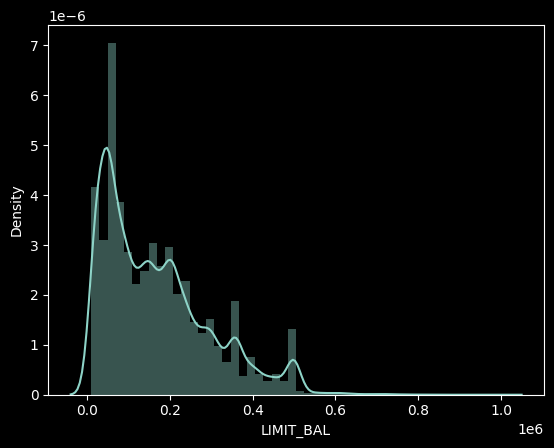

In [25]:
# distplot을 통해 데이터 분포 확인
sns.distplot(df['LIMIT_BAL'])

In [26]:
df['LIMIT_BAL']

0         20000
1        120000
2         90000
3         50000
4         50000
          ...  
29995    220000
29996    150000
29997     30000
29998     80000
29999     50000
Name: LIMIT_BAL, Length: 30000, dtype: int64

In [27]:
# Numeric(연속형) 변수 구간화 작업
# 100,000 이하, 100,000초과 300,000 이하, 300,000 초과 500,000 이하, 500,000 초과(4 그룹)

df['LIMIT_GP'] = np.where(df['LIMIT_BAL']<=100000,1,
                           np.where(df['LIMIT_BAL']<=300000, 2,
                            np.where(df['LIMIT_BAL']<=500000,3,4)))

df[['ID','LIMIT_BAL','LIMIT_GP']]

,ID,LIMIT_BAL,LIMIT_GP
0,1,20000,1
1,2,120000,2
2,3,90000,1
3,4,50000,1
4,5,50000,1
...,...,...,...
29995,29996,220000,2
29996,29997,150000,2
29997,29998,30000,1
29998,29999,80000,1


In [28]:
df['LIMIT_GP'].value_counts()

LIMIT_GP
2    12939
1    12498
3     4357
4      206
Name: count, dtype: int64

In [29]:
# 신용한도 > 100,000 이하, 100,000 초과 300,000 이하, 300,000 초과 500,000 이하, 500,000 초과
# 1단계
df_profile = pd.DataFrame(df['default payment next month'].groupby(df['LIMIT_GP']).value_counts())
df_profile.columns=['cnt']
df_profile = df_profile.reset_index()

# 2단계
df_profile = pd.pivot_table(df_profile,
                            index='LIMIT_GP',
                            columns='default payment next month',
                            values='cnt')

# 3단계
df_profile = df_profile.reset_index()
df_profile.columns.names=['']

# 4단계
df_profile['sign_ratio']=round((df_profile.iloc[:,2] / (df_profile.iloc[:,1] + df_profile.iloc[:,2]))*100, 1)
df_profile=df_profile.sort_values(by=['sign_ratio'], ascending=False)
df_profile

,LIMIT_GP,0,1,sign_ratio
0,1,8814,3684,29.5
1,2,10592,2347,18.1
2,3,3775,582,13.4
3,4,183,23,11.2


## Session 3
## ML 활용 채무 불이행 고객 예측

### 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔  
* 학습과 예측을 위한 Train/Test set 분할

In [30]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,PAY/BILL,LIMIT_GP
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,689,0,0,0,0,1,8.9,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3261,0,1000,1000,1000,0,2000,1,29.3,2
2,3,90000,2,2,2,34,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,10.8,1
3,4,50000,2,2,1,37,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,3.6,1
4,5,50000,1,2,1,57,-1,0,-1,0,...,19131,2000,36681,10000,9000,689,679,0,54.0,1


## Session 3
## ML 활용 채무 불이행 고객 예측


### 모델링을 위한 데이터 준비
--- * 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터 구분  
* 학습과 예측을 위한 Train/Test set 분할

In [31]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,PAY/BILL,LIMIT_GP
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,689,0,0,0,0,1,8.9,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3261,0,1000,1000,1000,0,2000,1,29.3,2
2,3,90000,2,2,2,34,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,10.8,1
3,4,50000,2,2,1,37,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,3.6,1
4,5,50000,1,2,1,57,-1,0,-1,0,...,19131,2000,36681,10000,9000,689,679,0,54.0,1


In [35]:
# 모델링을 학습하기 위한 Feature(X)와 Y데이터 구분
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# 상위에서 생성한 그룹핑 변수들은 우선 제거 후 모델링 진행
X=df.drop(['ID','default payment next month', 'PAY/BILL','LIMIT_GP'], axis=1)
Y=df['default payment next month']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(21000, 23)
(21000,)
(9000, 23)
(9000,)


### 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능 평가

In [36]:
# 학습
from sklearn.metrics import classification_report
rfc = RandomForestClassifier(random_state=123456)
rfc.fit(x_train, y_train)

# 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16355
           1       1.00      1.00      1.00      4645

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.65      0.37      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000



In [37]:
# ROC 개념 (0.7599657511448114 -> 0.7635140698416093)
# 이진 분류기 성능을 평가할 떄, 사용하는 지표, 100에 가까울수록 모델 성능이 좋은 것 (※ 다양한 threshold에 대한 이진분류기의 성능을 한번에 표시한 것)
# 과적합 문제, Train과 Test set에 성능을 최대한 줄여주는 것이 과적합을 방지
from sklearn.metrics import roc_auc_score

y_pred_train_proba = rfc.predict_proba(x_train)[:,1]
y_pred_test_proba = rfc.predict_proba(x_test)[:,1]

roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print('roc_score_train: ', roc_score_train)
print('roc_score_test: ',roc_score_test)

roc_score_train:  0.9999968737237801
roc_score_test:  0.7635140698416093


### Hyper parameter 튜닝
---
* 모델 성능을 올리기위한 옵션 조절

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[400,500],
          'max_depth':[6,8,10,12]}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 123456, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=3, n_jobs=-1, scoring='precision')
grid_cv.fit(x_train, y_train)

print('최적 하이퍼파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

In [40]:
# Best score 기준 재학습
rfc = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=123456)
rfc.fit(x_train, y_train)

# 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90     16355
           1       0.72      0.36      0.48      4645

    accuracy                           0.83     21000
   macro avg       0.78      0.66      0.69     21000
weighted avg       0.81      0.83      0.80     21000

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7009
           1       0.69      0.33      0.45      1991

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.67      9000
weighted avg       0.80      0.82      0.79      9000



In [41]:
# 과적합 해결
from sklearn.metrics import roc_auc_score

y_pred_train_proba = rfc.predict_proba(x_train)[:, 1]
y_pred_test_proba = rfc.predict_proba(x_test)[:, 1]


roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print("roc_score_train :", roc_score_train)
print("roc_score_test :", roc_score_test)

roc_score_train : 0.791679386223126
roc_score_test : 0.7799046701740081


### 중요 변수 파악
---
* Feature IMP 분석을 통한 중요변수 파악

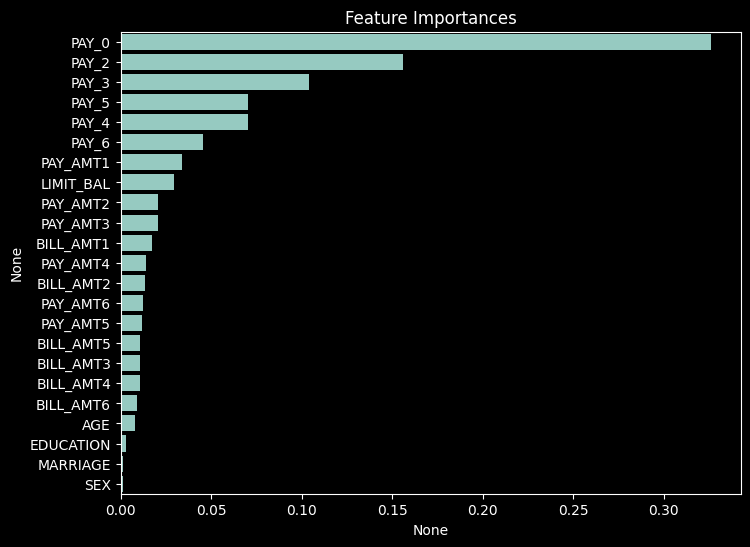

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.rc('xtick', labelsize=5)
plt.show()

### 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [ ]:
import pickle
# 모델 저장
saved_model = pickle.dumps(rfc)

# 모델 Read
clf_from_pickle = pickle.loads(saved_model)